In [248]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

In [249]:
SIZE = 128
_img = []
path = '../input/healthy/Healthy'
files = os.listdir(path)
for i in tqdm(files):    
            img = cv2.imread(path + '/'+i,1)
            # converting it to RGB as open cv reads images in BGR format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing the images
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            _img.append(img_to_array(img))

100%|██████████| 365/365 [00:01<00:00, 309.06it/s]


In [251]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

# Generator


In [252]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [253]:
generator = Generator()
generator.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 49152)             4915200   
_________________________________________________________________
reshape_14 (Reshape)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 128, 128, 128)     6144      
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 64, 64, 128)       262144    
_________________________________________________________________
batch_normalization_126 (Bat (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 64, 64, 256)     

# Discriminator


In [254]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [255]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 64, 64, 128)       6144      
_________________________________________________________________
batch_normalization_131 (Bat (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_130 (LeakyReLU)  (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 32, 32, 128)       262144    
_________________________________________________________________
batch_normalization_132 (Bat (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_131 (LeakyReLU)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 16, 16, 256)     

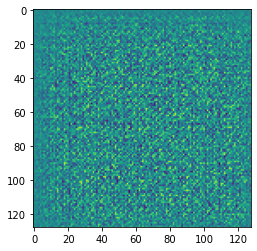

In [256]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

### Loss function and Optimizer 

In [257]:
optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [258]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

### Training 

In [259]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [260]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [261]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='disc_loss',
    patience=10,
    restore_best_weights=True,
)

In [262]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [263]:
train(100,dataset)


Epoch : 1
 Time:10.0
Generator Loss: 7.523201942443848 Discriminator Loss: 0.9880279302597046

Epoch : 2
 Time:10.0
Generator Loss: 0.36333978176116943 Discriminator Loss: 1.3841688632965088

Epoch : 3
 Time:10.0
Generator Loss: 0.44884663820266724 Discriminator Loss: 1.4110534191131592

Epoch : 4
 Time:10.0
Generator Loss: 0.7070229649543762 Discriminator Loss: 1.3133244514465332

Epoch : 5
 Time:10.0
Generator Loss: 0.5740200281143188 Discriminator Loss: 0.9106865525245667

Epoch : 6
 Time:10.0
Generator Loss: 14.580479621887207 Discriminator Loss: 5.974308490753174

Epoch : 7
 Time:10.0
Generator Loss: 0.9451585412025452 Discriminator Loss: 0.5303423404693604

Epoch : 8
 Time:10.0
Generator Loss: 0.02901085466146469 Discriminator Loss: 3.8035995960235596

Epoch : 9
 Time:10.0
Generator Loss: 1.150353193283081 Discriminator Loss: 0.4692929983139038

Epoch : 10
 Time:10.0
Generator Loss: 2.2538585662841797 Discriminator Loss: 0.18920131027698517

Epoch : 11
 Time:10.0
Generator Loss:

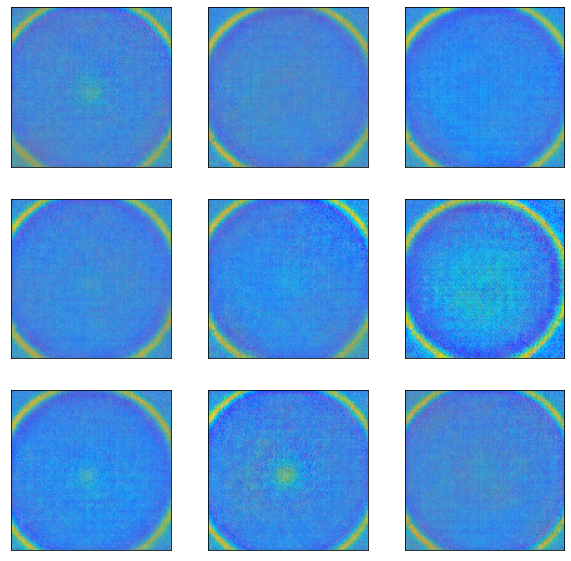

In [264]:
plot_generated_images(3)

In [265]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")